# COGS 108 - Final Project 

# Overview

Food health has always being the center topic of nowaday's society, and since more and more people are willing to have dinner in nearby restaurants, the health issue of restaurants should be seriously treated. Therefore, in this project, I will formulate several questions and hypothesis to help goverment improve their restaurants health inspections.
    
In this project, I will discusss several factors that correlate to the score of each inspection, and then build my regression model to predict one restaurant's health inspection score given features of that restaurant. Futhermore, I will check any anomelies generated in the inspection process and give advises to inspector accordingly. 

# Name & GitHub

- Name: Xiangchen Zhao
- GitHub Username: zxchen98

# Research Question

In order to make the health inspection more accurate and effcient, I would like to propose the following questions and try to answer them with the dataset provided.

#### Main Question:  What features contribute to inspection score the most? in other words, what aspects of one restaurant can most accurately influence its inspection score.

In order to answer this main question, I would like To divide all the features into two groups and generate some sub-questions before answering the main question.

###### For Restaurants:

1. How do restaurant type, location, or even yelp rating correlates to restaurant's inspection score.

###### For Inspection process:

1. Is there a correlation between the result of inspection and how often the inspection occur? If so, what is the best time period between two inspections in order to have a strong supervision as well as a high efficiency?

2. Second, is inspection score highly depend on inspector and the number of previous inspections.

## Background and Prior Work

Why health inspection: the goverment wants to protect customers against contamination and food poisoning from the restaurant (source website:https://www.lightspeedhq.com/blog/restaurant-health-inspection/)

Futher testing: The inspectors are also going to be looking for knowledge from your managers and staff. Restaurant owners are required to know all of the local health codes. Management is required to have all up-to-date training on food safety and all restaurant employees must demonstrate knowledge of safe food handling and preparation. All of this is this is the knowledge that is tested as part of the Food Handler’s Permit, but the inspector will ask questions to test this knowledge.

The grading system:
(source website:https://www.sandiegocounty.gov/content/sdc/deh/fhd/ffis/intro.html.html)

1. Each violation on the Food Inspection Report is assigned a point value depending on its importance. For example, a Major Risk Factor is worth four points, a Minor Risk Factor is worth two, and a Good Retail Practice is worth one.

2. Once the Specialist completes an inspection, the points are added up and subtracted from 100. The resulting number is the inspection "score".

3. A letter grade is assigned to the facility based on the inspection score. An "A" grade means the facility earned a score of 90 to 100 percent and is in satisfactory compliance with state law; a "B" means the facility earned a score of 80 to 89 percent and needs improvement; a "C" means the facility earned a score of 79 percent or less and is a failing grade. However in this inspections.csv, a letter grade has not been assigned to each restaurant, instead a score out of 100 is being assigned.

References (include links):
- 1)https://www.lightspeedhq.com/blog/restaurant-health-inspection/
- 2)https://www.sandiegocounty.gov/content/sdc/deh/fhd/ffis/intro.html.html

# Hypothesis


Restaurants' information (including yelp rating, location, restaurant type) is a strong and accurate feature in predicting inspection score, and thus could be used to analysis score pattern in order to improve restaurants'health condition.

# Dataset(s)

- Dataset Name: inspections.csv
- Link to the dataset: https://canvas.ucsd.edu/courses/12630/files?preview=1639871
- Number of observations: 18466

The inspections.csv includes information of over 10,000 inspection records, including restaurant name and location, latest and previous inspection score, inspector name, and etc.

- Dataset Name: yelp.csv
- Link to the dataset: https://canvas.ucsd.edu/courses/12630/files?preview=1639871
- Number of observations: 3688

This yelp.csv contains customer ratings and other restaurant information. This dataset can provide a good set of features to predict inspection score. Thus by merge yelp.csv and inspection.csv, we could try to predict one restaurant's score using features just relate to that restaurant itself.

- Dataset Name: zipcodes.csv
- Link to the dataset: https://canvas.ucsd.edu/courses/12630/files?preview=1639871
- Number of observations: 38

zipcodes.csv contains information in some of zipcode areas. Information includes median income of some social classes, percentage of non-white people, etc. This data set can provide regional analysis to restaurant types and class and futher predict the score of those restaurants.

# Setup

In [28]:
# some libraries to import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, ensemble

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder

# set max number of displaying columns to be none
pd.set_option('max_columns',None)

In [29]:
# read csv into pandas dataframe
inspection=pd.read_csv('inspections.csv')
restaurant=pd.read_csv('restaurants.csv')
violation=pd.read_csv('violations.csv')
yelp=pd.read_csv('yelp.csv')
zipcode=pd.read_csv('zipcodes.csv')

# Data Cleaning

In order to explore more features that could influence health inspection score, we need to merge as many dataset as possible into one large dataset. 
First, let's merge yelp and restaurant together.

In [30]:
#check columns in common that can be merged on
intersect=[i for i in yelp.columns if i in inspection.columns]
intersect

['name', 'address1']

In [31]:
# before merge them together, I notice there are restaurants share the same address
# drop those restaurants before merge
yelp.drop_duplicates('address1',inplace=True)

In [32]:
# we choose address to be the merged column and join
yelp_inspection=pd.merge(yelp,inspection,on='address1',how='inner')
yelp_inspection.head(3)

,id,name_x,is_closed,rating,review_count,address1,zip_code,latitude,longitude,price,phone,hotdogs,sandwiches,pizza,tradamerican,burgers,mexican,grocery,breakfast_brunch,coffee,chinese,italian,newamerican,chicken_wings,delis,bars,salad,seafood,bbq,bakeries,sushi,hsisid,date,name_y,address2,city,state,postalcode,phonenumber,restaurantopendate,days_from_open_date,facilitytype,x,y,geocodestatus,zip,type,description,inspectedby,inspection_num,inspector_id,previous_inspection_date,days_since_previous_inspection,previous_inspection_by_same_inspector,score,num_critical,num_non_critical,num_critical_previous,num_non_critical_previous,num_critical_mean_previous,num_non_critical_mean_previous,avg_neighbor_num_critical,avg_neighbor_num_non_critical,top_match,second_match,critical
0,southern-womens-show-raleigh,southern women's show,False,4.0,9,1025 Blue Ridge Rd,27607,35.79567,-78.71228,NaN,17043766594,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,4092014036,2013-02-01T00:00:00Z,Murphy House Restaurant-Dorton Arena,NaN,raleigh,NC,27607,(919) 522-0834,2004-05-07T00:00:00Z,3192,Restaurant,-78.715161,35.796348,M,27607,Inspection,NaN,Chris Askew,1,6.0,NaN,NaN,NaN,97.5,2,4,NaN,NaN,NaN,NaN,0.6,2.2,4.092040e+09,4.092022e+09,1
1,southern-womens-show-raleigh,southern women's show,False,4.0,9,1025 Blue Ridge Rd,27607,35.79567,-78.71228,NaN,17043766594,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,4092021276,2013-02-01T00:00:00Z,Murphy House Restaurant-Kerr Scott Building,NaN,raleigh,NC,27607,(919) 522-0834,2004-06-17T00:00:00Z,3151,Food Stand,-78.715161,35.796348,M,27607,Inspection,NaN,Chris Askew,1,6.0,NaN,NaN,NaN,98.0,1,6,NaN,NaN,NaN,NaN,0.6,2.2,4.092040e+09,4.092022e+09,1
2,southern-womens-show-raleigh,southern women's show,False,4.0,9,1025 Blue Ridge Rd,27607,35.79567,-78.71228,NaN,17043766594,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,4092021276,2013-08-24T00:00:00Z,Murphy House Restaurant-Kerr Scott Building,NaN,raleigh,NC,27607,(919) 522-0834,2004-06-17T00:00:00Z,3355,Food Stand,-78.715161,35.796348,M,27607,Inspection,NC FOOD CODE MANUAL: To learn more about the ...,Lucy Schrum,2,25.0,2013-02-01T00:00:00Z,204.0,False,94.5,5,12,1.0,6.0,1.0,6.0,1.4,2.5,4.092040e+09,4.092022e+09,1


In [33]:
# some cleaning on yelp_inspection
# first drop some overlapping columns
overlap=['id','name_y','address2','x','y','zip']
yelp_inspection.drop(columns=overlap,inplace=True)
yelp_inspection.shape

(970, 60)

Now that we merge yelp and inspection together, we also want to take a look at the information of each zipcode that restaurant locates in.

In [34]:
# clean zipcode columns in both datasets
yelp_inspection['zip_code']=yelp_inspection['zip_code'].astype(str)
yelp_inspection.rename({'zip_code':'zipcode'},inplace=True,axis=1)

zipcode.rename({'zip':'zipcode'},axis=1,inplace=True)
zipcode['zipcode']=zipcode['zipcode'].astype(str)

# merge zipcode and yelp_inspection together
df=pd.merge(zipcode,yelp_inspection,on='zipcode',how='inner')
df.shape

(970, 67)

In [35]:
#check the number of nulls in df
print(df.isna().sum().sort_values(ascending=False).head(10))
# drop some columns base on the number of nulls
df.drop(columns=['description','phonenumber'],inplace=True)
# fillna with median
df.fillna('nan',inplace=True)

description                              522
price                                    139
num_non_critical_mean_previous           135
num_critical_mean_previous               135
num_non_critical_previous                135
num_critical_previous                    135
previous_inspection_by_same_inspector    135
days_since_previous_inspection           135
previous_inspection_date                 135
phonenumber                               32
dtype: int64


Notice that there are columns represent the food type in a restaurant (those columns have been one hot encoded). I want to transfer them back into uncoded condition, I create a new column called 'food_type' that contains the restaurant type.

In [37]:
#get restaurant type list
type_list=df.columns[17:37]

In [38]:
# helper function to get food_type
def get_type(x):
    for i in type_list:
        if x[i]==True:
            return i
    return 'other'

# create food_type column
df['food_type']=df.apply(get_type,axis=1)
df.drop(columns=type_list,inplace=True)

In [39]:
# clean price column
df['price']=df['price'].replace('$$','high') 
df['price']=df['price'].replace('$','low')
# clean days_since_previous_inspection columns
df['days_since_previous_inspection']=df['days_since_previous_inspection'].astype(str)
df['days_since_previous_inspection']=df['days_since_previous_inspection'].replace('median','0')
df['days_since_previous_inspection']=df['days_since_previous_inspection'].astype(float)
df['days_since_previous_inspection']=df['days_since_previous_inspection'].fillna(0)

# Data Analysis & Results

Fist let's visualize the relationshaip between inspection score and other features in our dataset. I will seperate those features into two groups: one relate to restaurant itself, and one relate to inspection. Through visualization and correlation metrix, I would like to find features that can be used in our regression model.

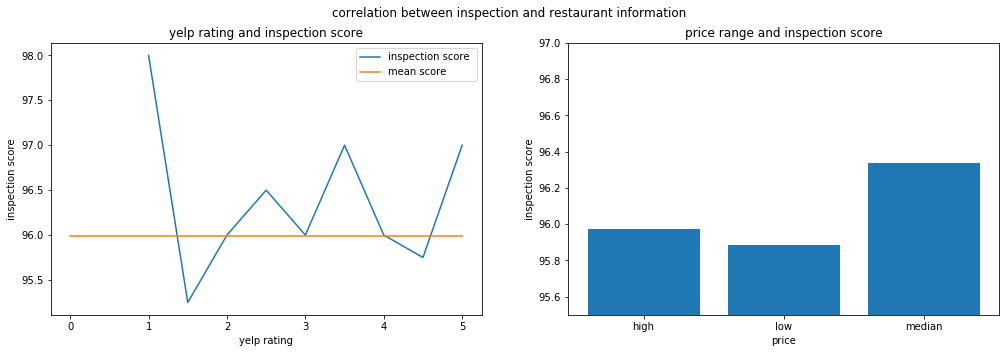

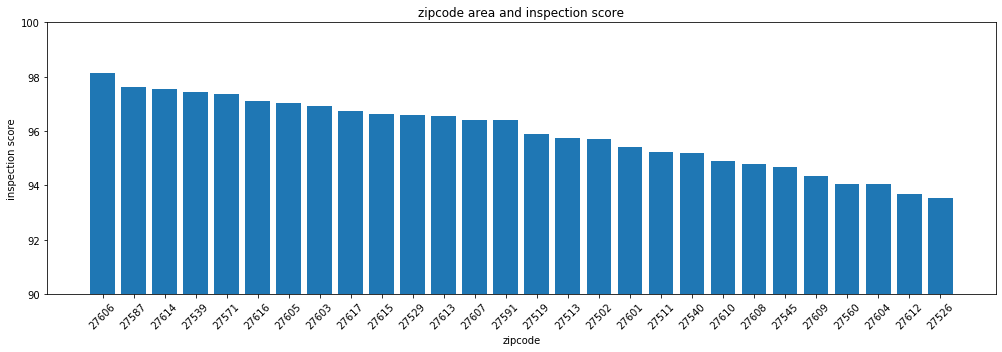

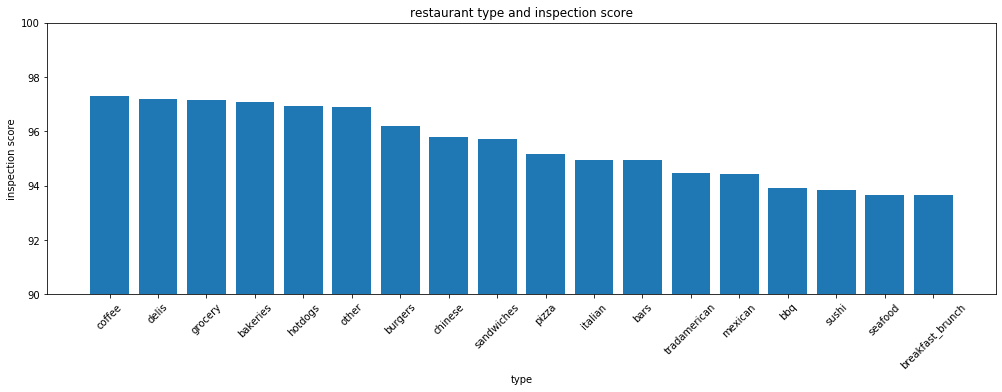

In [40]:
# plot line chart for yelp rating and inspection score
# first groupby rating and calculate mean score 
fig=plt.figure(figsize=(17,5))
fig.suptitle('correlation between inspection and restaurant information') 
plt.subplot(1,2,1)
# plot the line chart between rating and score
grouped_rating=df.groupby('rating').median()['score']
plt.title('yelp rating and inspection score')
plt.xlabel('yelp rating')
plt.ylabel('inspection score') 
plt.plot(grouped_rating.index,grouped_rating.values,label='inspection score ')
#plot mean inspection score'
plt.plot([df['score'].mean()]*6,label='mean score') 
plt.legend()


#plot the bar chart between price and inspection
plt.subplot(1,2,2)
plt.title('price range and inspection score') 
plt.xlabel('price')
plt.ylabel('inspection score') 
price_score=df.groupby('price').mean()['score'] 
plt.bar(['high','low','median'],height=price_score.values) 
#I limit the y axis to make the difference larger
#but still the difference is very small
plt.ylim(95.5,97)
plt.show()


#plot bar chart between score and zipcode
plt.figure(figsize=(17,5))
plt.title('zipcode area and inspection score') 
plt.xlabel('zipcode')
plt.xticks(rotation=45)
plt.ylabel('inspection score') 
zip_score=df.groupby('zipcode').mean()['score'] 
#sort into descending order 
zip_score=zip_score.sort_values(ascending=False) 
plt.bar(zip_score.index,zip_score.values) 
plt.ylim(90,100)
plt.show()


#plot bar chart between score and restaurant type
plt.figure(figsize=(17,5))
plt.title('restaurant type and inspection score') 
plt.xlabel('type')
plt.xticks(rotation=45)
plt.ylabel('inspection score') 
type_score=df.groupby('food_type').mean()['score'] 
#sort into descending order 
type_score=type_score.sort_values(ascending=False) 
plt.bar(type_score.index,type_score.values) 
plt.ylim(90,100)
plt.show()

From above charts, we can see inspection score can have strong relationship with restaurant location(zipcode area), and food type it provides, however there is none strong linear relation between score and price or yelp rating. Then, we want to futher caculate the correlation matrix to show their correlation in numerical data with the help of seaborn library.

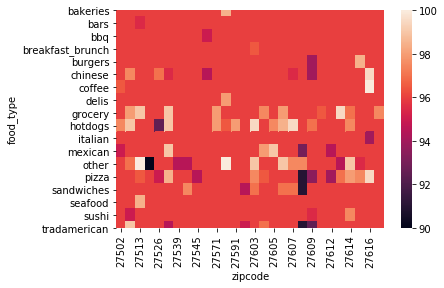

In [41]:
#caculate the correlation metrix between restaurants' information and score 
#I do not include price column 
res_info=df[['score','zipcode','food_type']].drop_duplicates(subset=['zipcode','food_type'])
corr=res_info.pivot('food_type','zipcode','score') 
corr.fillna(df['score'].mean(),inplace=True)
sns.heatmap(corr)

The above correlation heatmap shows that those restaurants with certain food types have higher inspection score than others for example grocery and hotdogs restaurants. Besides, some zipcode areas have lower inspection score in general than any other areas. for example zipcode 27609

### Regression model base on restaurant information

Now, with above information, I would like to build a regressor that just takes one restaurant's information as features and predict that inspection score. Considering the features contain both numeric and nominal data, I deceide to use random forest regressor to train and predict the data.

Before training the data, we need to label encode the nominal data such as zipcode and food type

In [42]:
#select all features from dataset
alldata=df[['zipcode','food_type','price','rating','review_count','score']]
#select just numerical data
num=alldata[['rating','review_count','score']]
#select nominal data
nominal=alldata[['zipcode','food_type','price']]

# label encode the nominal features
le1 = LabelEncoder()
le1.fit(nominal['zipcode'])
nominal['zipcode']= le1.transform(nominal['zipcode']) 

le2 = LabelEncoder()
le2.fit(nominal['food_type'])
nominal['food_type']= le2.transform(nominal['food_type']) 

le3 = LabelEncoder()
le3.fit(nominal['price'])
nominal['price']= le3.transform(nominal['price']) 

modify=pd.concat([nominal,num],axis=1).reset_index(drop=True)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [43]:
# train-test split and train the random forest regressor
X=modify[['zipcode','food_type','price','rating','review_count']]
y=modify['score']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

regr = RandomForestRegressor(max_depth=30)
regr.fit(X_train, y_train)
predict=regr.predict(X_test)

# evaluate RMSE of predicted result
rmse=mean_squared_error(y_test, predict)
print('Model with restaurant information as features has prediction RMSE of: '+str(rmse))

Model with restaurant information as features has prediction RMSE of: 3.326137457818066


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Now we have a model using restaurants information as features and get a rmse around 4. Then, in order to justify our hypothesis, I also need to creat another model which use features relate to inspection process for example(inspecor, days since last inspect, etc) and check the performance of that model. If the next model turns out perform better than this one, I can not justify my hypothesis which means the inspection result does not completly reflect the true health condition of one restaurant.

Samiliarly, let us visualize some relationship between features and inspection score

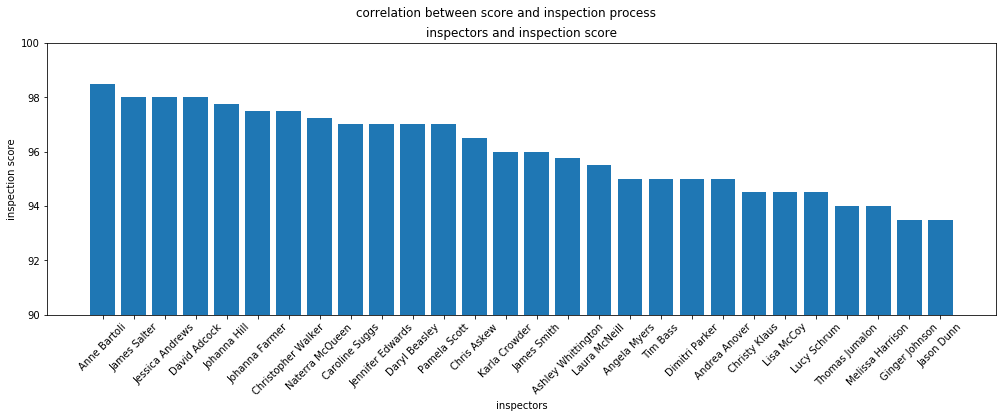

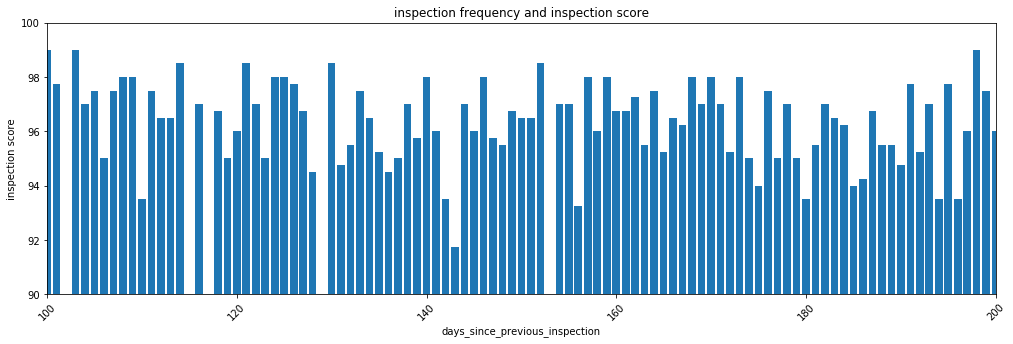

In [54]:
fig=plt.figure(figsize=(17,5))
fig.suptitle('correlation between score and inspection process') 
# check if inspector has strong correlation with score
grouped_rating=df.groupby('inspectedby').median()['score'].sort_values(ascending=False)
plt.title('inspectors and inspection score')
plt.xlabel('inspectors')
plt.ylabel('inspection score') 
plt.ylim(90,100)
plt.xticks(rotation=45)
plt.bar(grouped_rating.index,grouped_rating.values)
plt.show()

# check if the frequency of inspection influence score
fig=plt.figure(figsize=(17,5))
plt.title('inspection frequency and inspection score') 
grouped_rating=df.groupby('days_since_previous_inspection').median()['score'].sort_values(ascending=False)
plt.title('inspection frequency and inspection score')
plt.xlabel('days_since_previous_inspection')
plt.ylabel('inspection score') 
plt.ylim(90,100)
plt.xlim(100,200)
plt.xticks(rotation=45)
plt.bar(grouped_rating.index,grouped_rating.values)
plt.show()

The first bar plot shows that there is some kind of correlation between inspector and score. Some of the inspector tend to give lower or higher grade than others, however we can not say that they are unfair inspectors because we do not know if the area they inspect are different from others, for example, if an area is dirtier than other areas, the inspector of that area will give lower grade than other inspectors.

From the second graph, I try to find a pattern between the frequency and score, I made an assumption in my question part that if the inspection happened more regularly, the inspection result will be higher. However, we see no such pattern in this bar graph and thus we can have a negative answer to that assumption.

### Regression model base on inspection process

In [51]:
#select all features from dataset
modify=df[['inspector_id','days_since_previous_inspection','median_household_income_dollars','percent_damilies_below_poverty_line','score']]

#replace nan


# train-test split and train the random forest regressor
X=modify[['inspector_id','days_since_previous_inspection','median_household_income_dollars','percent_damilies_below_poverty_line']]
y=modify['score']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

regr = RandomForestRegressor(max_depth=30)
regr.fit(X_train, y_train)
predict=regr.predict(X_test)

# evaluate RMSE of predicted result
rmse=mean_squared_error(y_test, predict)
print('Model with inspection process as features has prediction RMSE of: '+str(rmse))

Model with inspection process as features has prediction RMSE of: 5.848797517462979


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# Ethics & Privacy

1. The detail personal information of the restaurant owener should be hidden from the dataset
2. A consent from the owner should be given in order to acquire the attribute: "number of complains" , and the personal information of complainer should also be hidden
3. The information of each inspectors is hidden and excluded from dataset.
4. Treat each restaurant equally, and each restaurant contribute equally to my analysis. As you can see I did not use any names in my model building and analytics and thus avoid bias.

# Conclusion & Discussion

In this project, I want to find out what features can most strongly predict the inspection result. I divide those features into two groups, one relates to restraurant itself, another one relate to the inspection process. Then after visualizing and analytics, I build two regressor for each one of these two groups to predict inspection score. 

As we can see from above model rmse result, the model which builded on restaurant information feature performs much better than model build on inspection process. This means that this inspection process is fair to all of the restaurants, because the inspection result does not rely on the inspector or frequncy of inspection or even situation of its neighborhood. Thus, we now know the best way to earn a good inspection score is to improve the health condition of a restaurant, and some information such as: yelp rating and restaurant type will also provide information about the environment of that restaurant.

Additionaly, we learned even though some inspector tend to give lower(or higher) inspection score than others, it does not influence the general fairness of the inspection process Because their score can be influenced by the cleaniess of neighborhood or any other factors.

Last but not the least, this project also has some drawbacks that have not been solved. For example, I notics several restaurants share the same address and thus share the same inspection information when I try to merge two dataset, that will lead to unaccuracy of my model. Besides, I also do not check the dependance of features I use, if the rating column largly correlate to food_type, that will also decrease the accuracy of my result, but in general, I still can justify my hypothesis that the inspection result can be mostly influenced by restaurant itself, not inspection process.